In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import resize
from skimage.morphology import skeletonize, binary_dilation
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import copy
from torch_geometric.utils import negative_sampling, train_test_split_edges, to_undirected, remove_self_loops
import matplotlib.pyplot as plt
from torch_geometric.nn import GINConv, JumpingKnowledge
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F
import random
from torch.utils.data import Subset
import pandas as pd
import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data inladen

In [3]:
test_targets = np.load('test_targets2.npy')

test_labels = np.load('y_test_targets2.npy')

In [4]:
test_targets = test_targets.squeeze()

# GNN functies inladen

In [5]:
def resize_with_padding(img, target_size=64, inner_size=60):
    """
    Resize afbeelding proportioneel zodat het in 'inner_size' past
    en vul aan met padding tot 'target_size' x 'target_size'.
    """
    h, w = img.shape
    scale = min(inner_size / h, inner_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = resize(img, (new_h, new_w), mode='constant', anti_aliasing=True)
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(resized, ((top, bottom), (left, right)), mode='constant', constant_values=0)

def preprocess_image(img, target_size=64, inner_size=60):
    """
    Preprocess een grijswaarde-afbeelding tot een skeleton:
    normalisatie, Otsu-binarisatie, crop, resize, smooth, skeletonize.
    """
    img = img / 255.0 if img.max() > 1 else img
    threshold = threshold_otsu(img)
    binary = img > threshold

    rows, cols = np.any(binary, axis=1), np.any(binary, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    margin = 1
    rmin = max(rmin - margin, 0)
    rmax = min(rmax + margin, img.shape[0] - 1)
    cmin = max(cmin - margin, 0)
    cmax = min(cmax + margin, img.shape[1] - 1)
    cropped = img[rmin:rmax+1, cmin:cmax+1]

    resized = resize_with_padding(cropped, target_size, inner_size)
    smoothed = gaussian(resized, sigma=1.0)
    binary = smoothed > threshold_otsu(smoothed)

    skeleton1 = skeletonize(binary)
    dilated = binary_dilation(skeleton1)
    skeleton = skeletonize(dilated)
    return skeleton

def skeleton_to_graph(skeleton):
    """
    Zet een skeleton afbeelding om naar een graf waarbij pixels knopen zijn
    en randen tussen naburige skeletpunten worden gelegd.
    """
    coords = np.argwhere(skeleton)
    G = nx.Graph()
    for y, x in coords:
        G.add_node((x, y))
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < skeleton.shape[0] and 0 <= nx_ < skeleton.shape[1]:
                    if skeleton[ny, nx_]:
                        G.add_edge((x, y), (nx_, ny))
    return G

def project_graph_to_grid(G, grid_size=8, image_size=64):
    """
    Projecteer een graf op een raster van formaat grid_size x grid_size.
    Elke knoop wordt gemapt naar een cel en randen tussen cellen worden toegevoegd.
    """
    cell_size = image_size // grid_size
    G_projected = nx.Graph()
    point_to_cell = {}
    added_edges = set()

    for x, y in G.nodes:
        cx = int(x / cell_size)
        cy = int(y / cell_size)
        cell = (cx, cy)
        point_to_cell[(x, y)] = cell
        G_projected.add_node(cell)

    for u, v in G.edges:
        cu = point_to_cell.get(u)
        cv = point_to_cell.get(v)
        if cu and cv and cu != cv:
            edge = tuple(sorted((cu, cv)))
            if edge not in added_edges:
                G_projected.add_edge(*edge)
                added_edges.add(edge)

    return G_projected


def graph_to_pyg_data(G, grid_size=8, label=None):
    """
    Zet een graf om naar een PyTorch Geometric 'Data' object
    met one-hot node features, bidirectionele randen en optioneel een label.
    """
    num_nodes = grid_size * grid_size
    node_index_map = { (x, y): y * grid_size + x for x in range(grid_size) for y in range(grid_size) }

    features = []
    for y in range(grid_size):
         for x in range(grid_size):
            idx = y * grid_size + x
            one_hot = torch.zeros(num_nodes)
            one_hot[idx] = 1.0
            features.append(one_hot)

    x = torch.stack(features) 

    edge_index = []
    for (u, v) in G.edges:
        uid = node_index_map.get(u)
        vid = node_index_map.get(v)
        if uid is not None and vid is not None:
            edge_index.append([uid, vid])
            edge_index.append([vid, uid])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)

    if label is not None:
        data.y = torch.tensor([label], dtype=torch.long)

    return data


In [6]:
class PyGSkeletonDataset(Dataset):
    def __init__(self, images, labels=None, grid_size=8):
        self.images = images
        self.labels = labels
        self.grid_size = grid_size
        self.graphs = [self._image_to_graph(img, i) for i, img in enumerate(images)]

    def _image_to_graph(self, img, idx):
        skeleton = preprocess_image(img)
        G = skeleton_to_graph(skeleton)
        G_proj = project_graph_to_grid(G, grid_size=self.grid_size)
        label = self.labels[idx] if self.labels is not None else None
        return graph_to_pyg_data(G_proj, grid_size=self.grid_size, label=label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]



class PyGSkeletonDataset(Dataset):
    """
    Dataset-klasse die afbeeldingen omzet in geskeletoniseerde grafen,
    geprojecteerd op een rooster, klaar voor gebruik in PyTorch Geometric.
    """
    def __init__(self, images, labels=None, grid_size=8):
        """
        Initialiseert de dataset door elke afbeelding om te zetten in een PyG graf.
        
        Args:
            images (list or array): Lijst van grijswaarde-afbeeldingen.
            labels (list or array, optional): Optionele labels per afbeelding.
            grid_size (int): Grootte van het raster (bijv. 8 voor 8x8).
        """
        self.images = images
        self.labels = labels
        self.grid_size = grid_size
        self.graphs = [self._image_to_graph(img, i) for i, img in enumerate(images)]

    def _image_to_graph(self, img, idx):
        """
        Zet één afbeelding om naar een geskeletoniseerde, gerasterde graf.
        
        Args:
            img (np.ndarray): Grijswaarde-afbeelding.
            idx (int): Index van de afbeelding, gebruikt om het juiste label te vinden.
        
        Returns:
            torch_geometric.data.Data: Graph-representatie van de afbeelding.
        """
        skeleton = preprocess_image(img)
        G = skeleton_to_graph(skeleton)
        G_proj = project_graph_to_grid(G, grid_size=self.grid_size)
        label = self.labels[idx] if self.labels is not None else None
        return graph_to_pyg_data(G_proj, grid_size=self.grid_size, label=label)

    def __len__(self):
        """
        Geeft het aantal grafen in de dataset.
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Haalt één PyG graf op uit de dataset.
        
        Args:
            idx (int): Index van het gewenste datapunt.
        
        Returns:
            torch_geometric.data.Data: De graf op positie idx.
        """
        return self.graphs[idx]



In [7]:
test_dataset = PyGSkeletonDataset(test_targets, test_labels, grid_size=8)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Vaste corupte test set maken

In [8]:
def zijn_directe_buren(u, v, max_afstand=1):
    """
    Controleert of twee knopen directe buren zijn op een 8x8 grid,
    met een maximaal toegestane afstand (default 1).
    """
    x1, y1 = u % 8, u // 8
    x2, y2 = v % 8, v // 8
    return max(abs(x1 - x2), abs(y1 - y2)) <= max_afstand and (u != v)


def get_local_negative_edges(data, ratio=2.0, max_afstand=1):
    """
    Genereert negatieve edges tussen nabije knopen die niet in de oorspronkelijke graf zitten.
    Bepaalt hoeveel negatives op basis van een ratio t.o.v. positieve edges.
    """
    num_nodes = data.num_nodes
    pos_edges = set(tuple(sorted((u.item(), v.item()))) for u, v in data.edge_index.t())
    candidate_edges = []

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if (i, j) in pos_edges or (j, i) in pos_edges:
                continue
            if zijn_directe_buren(i, j, max_afstand=max_afstand):
                candidate_edges.append([i, j])

    num_pos = data.edge_index.size(1)
    num_neg = min(len(candidate_edges), int(ratio * num_pos))

    perm = torch.randperm(len(candidate_edges))[:num_neg]
    selected = [candidate_edges[i] for i in perm]

    if not selected:
        return torch.empty((2, 0), dtype=torch.long)

    return torch.tensor(selected, dtype=torch.long).t()

def corrupt_graph_val(data, drop_rate=0.25, neg_ratio=2.0, max_afstand=1):
    """
    Corrupt een graf door willekeurige edges te verwijderen (drop_rate)
    en voegt local negative edges toe binnen max_afstand.
    Speciaal voor het genereren van vaste corrupte validatieset
    """
    edge_index = data.edge_index
    edge_index, _ = remove_self_loops(edge_index)

    edges = [tuple(sorted((u.item(), v.item()))) for u, v in edge_index.t()]
    unique_edges = list(set(edges))
    num_total = len(unique_edges)
    num_keep = int((1 - drop_rate) * num_total)

    perm = torch.randperm(num_total)[:num_keep]
    kept_edges = [unique_edges[i] for i in perm]
    kept_edges_tensor = torch.tensor(kept_edges, dtype=torch.long).t()
    edge_index_corrupt = to_undirected(kept_edges_tensor)

    data.edge_index = edge_index_corrupt
    data.pos_edge_label_index = torch.tensor(unique_edges, dtype=torch.long).t()
    data.neg_edge_label_index = get_local_negative_edges(data, ratio=neg_ratio, max_afstand=max_afstand)

    return data


def make_random_corrupted_testset(dataset, min_drop=0.0, max_drop=0.4, step=0.05, neg_ratio=2.0, max_afstand=1):
    """
    Genereert een corrupte testset waarbij elke sample een drop_rate krijgt
    toegewezen uit een vaste lijst tussen min_drop en max_drop met stapgrootte 'step'.
    """
    corrupted = []
    drop_rates = []

    possible_rates = np.arange(min_drop, max_drop + step, step)

    for data in dataset:
        data = copy.deepcopy(data)
        drop_rate = np.random.choice(possible_rates)
        data = corrupt_graph_val(data, drop_rate=drop_rate, neg_ratio=neg_ratio, max_afstand=max_afstand)
        corrupted.append(data)
        drop_rates.append(drop_rate)

    return corrupted, drop_rates



In [ ]:
test_dataset_corrupt, test_drop_rates = make_random_corrupted_testset(test_dataset)

test_loader_corrupt = DataLoader(test_dataset_corrupt, batch_size=16, shuffle=False)

drop_rate_df = pd.DataFrame({'sample_idx': list(range(len(test_drop_rates))), 'drop_rate': test_drop_rates})
drop_rate_df.to_csv("test_drop_rates.csv", index=False)


In [ ]:
drop_rate_df['drop_rate'] = drop_rate_df['drop_rate'].round(2)

indices_per_rate = drop_rate_df.groupby('drop_rate')['sample_idx'].apply(list).to_dict()


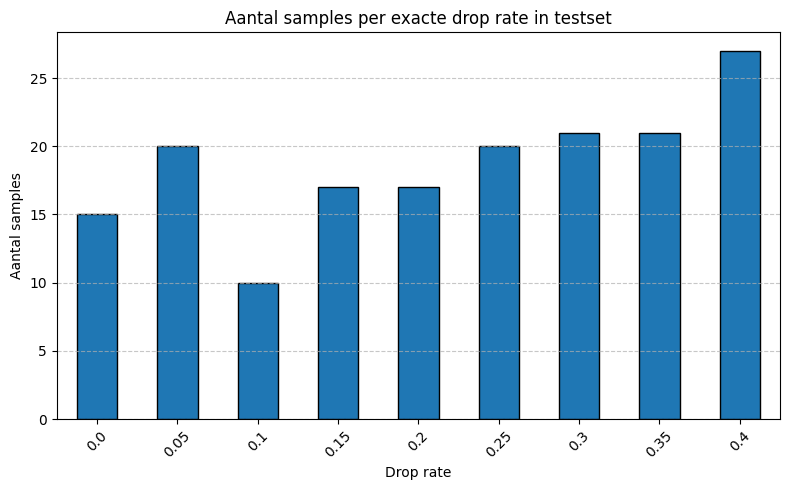

In [ ]:
drop_rate_df['drop_rate'] = drop_rate_df['drop_rate'].round(2)
rate_counts = drop_rate_df['drop_rate'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
rate_counts.plot(kind='bar', edgecolor='black')

plt.title("Aantal samples per exacte drop rate in testset")
plt.xlabel("Drop rate")
plt.ylabel("Aantal samples")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Model inladen

In [ ]:
# --- GIN Encoder met Jumping Knowledge over 3 lagen ---
class GINEncoderWithJK(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_dim = 2 * out_channels
        dropout_p = 0.3

        self.convs = torch.nn.ModuleList()
        for i in range(3):
            input_dim = in_channels if i == 0 else hidden_dim
            nn = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.BatchNorm1d(hidden_dim),
                torch.nn.Dropout(p=dropout_p),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(nn))

        self.jump = JumpingKnowledge(mode='cat')
        jk_dim = 3 * hidden_dim

        self.conv_mu = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))
        self.conv_logstd = GINConv(torch.nn.Sequential(
            torch.nn.Linear(jk_dim, out_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels, out_channels)
        ))

    def forward(self, x, edge_index):
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            xs.append(x)
        x = self.jump(xs)
        mu = self.conv_mu(x, edge_index)
        logstd = self.conv_logstd(x, edge_index)
        self.mu = mu
        self.logstd = logstd
        return mu, logstd

# --- MLP Decoder ---
class MLPDecoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * latent_dim, latent_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim, 1)
        )

    def forward(self, z, edge_index):
        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]
        z_pair = torch.cat([z_i, z_j], dim=1)
        return self.mlp(z_pair).squeeze()

# --- VGAE met MLP decoder ---
class VGAE_MLP(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index):
        mu, logstd = self.encoder(x, edge_index)
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index):
        return self.encode(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def recon_loss(self, z, pos_edge_index, neg_edge_index):
        pos_out = self.decoder(z, pos_edge_index)
        neg_out = self.decoder(z, neg_edge_index)
        
        preds = torch.cat([pos_out, neg_out])
        labels = torch.cat([
            torch.ones_like(pos_out),
            torch.zeros_like(neg_out)
        ])
        
        pos_weight = len(neg_out) / len(pos_out)
        pos_weight = torch.tensor(pos_weight, device=z.device)

        return F.binary_cross_entropy_with_logits(preds, labels, pos_weight=pos_weight)



    def kl_loss(self):
        mu, logstd = self.encoder.mu, self.encoder.logstd
        return -0.5 * torch.mean(1 + 2 * logstd - mu**2 - (2 * logstd).exp())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = GINEncoderWithJK(in_channels=64, out_channels=32)
decoder = MLPDecoder(latent_dim=32)
model = VGAE_MLP(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



# F1-score

In [13]:
def evaluate_link_prediction(model, loader, thresholds):
    """
    Evalueert een link prediction model op precision, recall en F1-score
    voor een reeks drempelwaarden op de voorspellingsscores.

    Args:
        model: Het getrainde model met 'encode' en 'decode' methoden.
        loader: DataLoader met batches die pos/neg edge labels bevatten.
        thresholds (list): Lijst met drempelwaarden (floats) voor classificatie.

    Returns:
        List van dicts met precision, recall en f1-score per drempelwaarde.
    """
    all_labels = []
    all_probs = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            # Encode stap
            z = model.encode(batch.x, batch.edge_index)

            # Combineer positieve en negatieve edges
            edge_label_index = torch.cat([
                batch.pos_edge_label_index,
                batch.neg_edge_label_index
            ], dim=-1)

            edge_labels = torch.cat([
                torch.ones(batch.pos_edge_label_index.size(1)),
                torch.zeros(batch.neg_edge_label_index.size(1))
            ], dim=0).to(device)

            pred_scores = model.decode(z, edge_label_index).sigmoid()

            all_probs.extend(pred_scores.cpu().numpy())
            all_labels.extend(edge_labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    results = []
    for thresh in thresholds:
        binary_preds = (all_probs >= thresh).astype(int)
        precision = precision_score(all_labels, binary_preds, average='binary', zero_division=0)
        recall = recall_score(all_labels, binary_preds, average='binary', zero_division=0)
        f1 = f1_score(all_labels, binary_preds, average='binary', zero_division=0)
        results.append({
            'threshold': thresh,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

    return results



In [14]:
model = torch.load("VGAE_final.pt", map_location=device, weights_only=False)
model.eval()

VGAE_MLP(
  (encoder): GINEncoderWithJK(
    (convs): ModuleList(
      (0-2): 3 x GINConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Linear(in_features=64, out_features=64, bias=True)
      ))
    )
    (jump): JumpingKnowledge(cat)
    (conv_mu): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
    (conv_logstd): GINConv(nn=Sequential(
      (0): Linear(in_features=192, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    ))
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1,

In [ ]:
thresholds = [0.96]
metrics_per_rate = []

for drop_rate, indices in sorted(indices_per_rate.items()):
    subset = Subset(test_dataset_corrupt, indices)
    loader = DataLoader(subset, batch_size=16, shuffle=False)
    results = evaluate_link_prediction(model, loader, thresholds)
    res = results[0]  # threshold = 0.95
    metrics_per_rate.append({
        "drop_rate": round(drop_rate, 2),
        "precision": round(res["precision"], 4),
        "recall": round(res["recall"], 4),
        "f1_score": round(res["f1_score"], 4)
    })

# Zet om naar tabel
metrics_table = pd.DataFrame(metrics_per_rate)
print(metrics_table)


   drop_rate  precision  recall  f1_score
0       0.00     0.8863  1.0000    0.9397
1       0.05     0.8544  0.9845    0.9149
2       0.10     0.8382  0.9942    0.9096
3       0.15     0.8498  0.9659    0.9042
4       0.20     0.8167  0.9608    0.8829
5       0.25     0.7948  0.9273    0.8559
6       0.30     0.8043  0.9193    0.8580
7       0.35     0.8338  0.8625    0.8479
8       0.40     0.8208  0.8568    0.8384


# Visualiseren reconstructies

In [ ]:
def reconstruct_edges(data, model, threshold=0.5):
    """
    Reconstrueert een edge index uit modelvoorspellingen.
    Bepaalt voor elk knopenpaar of er een rand bestaat op basis van drempel op predicties.
    """
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)

    num_nodes = data.num_nodes
    row, col = torch.meshgrid(torch.arange(num_nodes), torch.arange(num_nodes), indexing='ij')
    full_edge_index = torch.stack([row.flatten(), col.flatten()], dim=0).to(device)

    scores = model.decode(z, full_edge_index).sigmoid()

    keep = scores > threshold
    edge_index_reconstructed = full_edge_index[:, keep]

    return edge_index_reconstructed.cpu()

def zijn_directe_buren(u, v):
    """Controleer of twee knopen directe buren zijn op een 8x8 raster, inclusief diagonalen."""
    x1, y1 = u % 8, u // 8
    x2, y2 = v % 8, v // 8
    return max(abs(x1 - x2), abs(y1 - y2)) == 1 and (u != v)

def filter_directe_buren(edge_index):
    """Behoud alleen edges tussen directe buren."""
    filtered_edges = []
    for u, v in edge_index.t().tolist():
        if zijn_directe_buren(u, v):
            filtered_edges.append((u, v))
    return torch.tensor(filtered_edges).t()


def show_corrupt_vs_reconstruction(corrupted_data, reconstructed_edge_index, drop_rate=0.0):
    """
    Toont corrupte en gereconstrueerde graaf in één figuur.
    Verwijdert self-loops, behoudt alleen directe buren, en toont het label van de graaf.
    
    Args:
        corrupted_data: PyG Data object met de corrupte graaf.
        reconstructed_edge_index: edge_index van de gereconstrueerde graaf.
        drop_rate: toegepaste corruptie (float tussen 0 en 1).
    """
    reconstructed_edges, _ = remove_self_loops(reconstructed_edge_index)

    reconstructed_edges = filter_directe_buren(reconstructed_edges)

    label = corrupted_data.y.item() if hasattr(corrupted_data, 'y') else "?"

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    titel_corrupt = f"Kapotte graaf\n(corruptie: {drop_rate:.2f})"
    titel_recon = "Gereconstrueerde graaf"

    plot_graph(axes[0], corrupted_data.edge_index, titel_corrupt, color='blue')
    plot_graph(axes[1], reconstructed_edges, titel_recon, color='green')

    fig.suptitle(f"Label: {label}", fontsize=16)

    plt.tight_layout()
    plt.show()


    
def plot_graph(ax, edge_index, title, color='b'):
    """
    Plot een graf met knopen in een 8x8 raster op een gegeven subplot-as (ax).
    Maakt gebruik van NetworkX en tekent knopen, randen.
    """
    G = nx.Graph()
    positions = {i: (i % 8, 7 - i // 8) for i in range(64)}  

    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    G.add_nodes_from(range(64))  

    nx.draw(
        G,
        pos=positions,
        node_size=100,
        edge_color=color,
        node_color='gray',
        with_labels=False,
        ax=ax  
    )

    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(-0.5, 7.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off') 



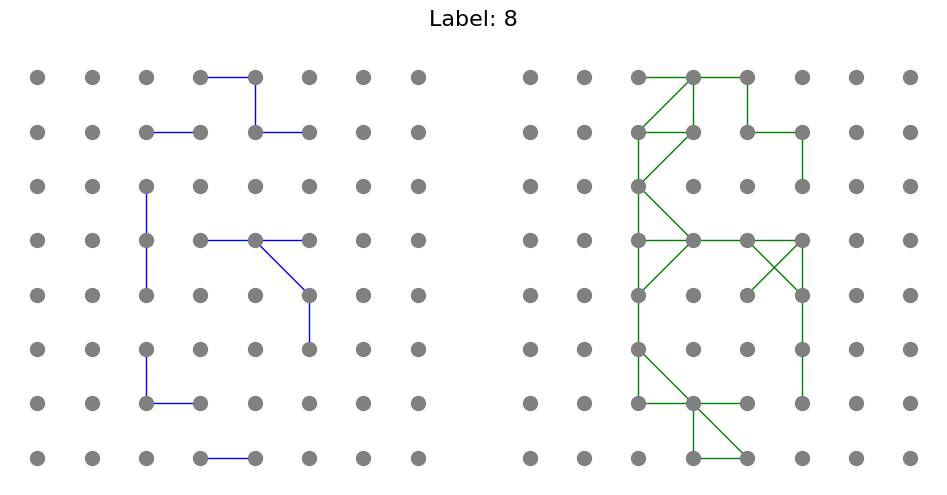

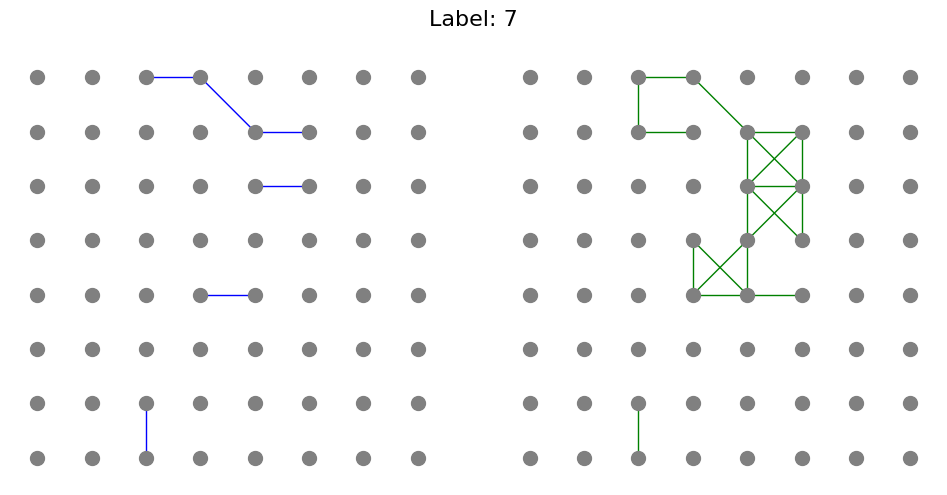

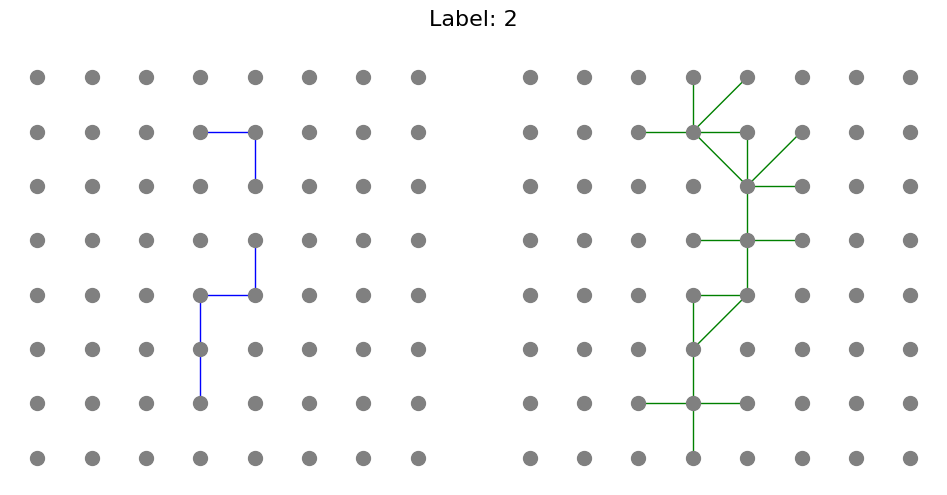

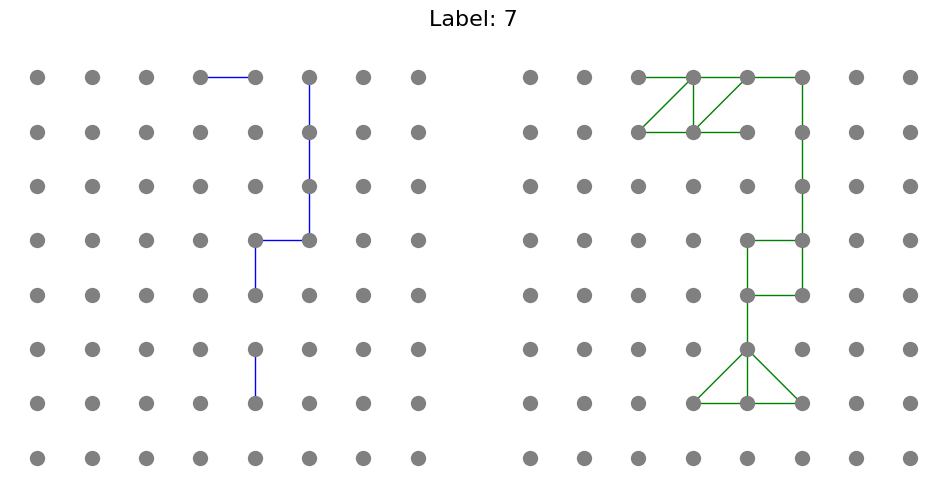

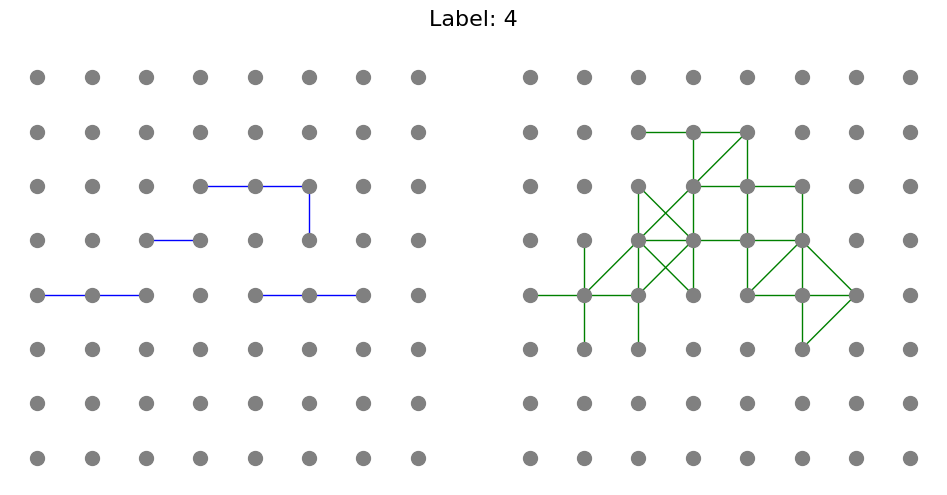

In [ ]:
target_drop_rate = 0.4
num_samples = 5
threshold = 0.96

selected_indices = random.sample(indices_per_rate[target_drop_rate], min(num_samples, len(indices_per_rate[target_drop_rate])))

for idx in selected_indices:
    corrupted_data = test_dataset_corrupt[idx]
    reconstructed_edge_index = reconstruct_edges(corrupted_data, model, threshold=threshold)
    show_corrupt_vs_reconstruction(corrupted_data, reconstructed_edge_index, drop_rate=target_drop_rate)


# F1-score binair beeld

In [ ]:
def resize_with_padding(img, target_size=64, inner_size=60):
    h, w = img.shape
    scale = min(inner_size / h, inner_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = resize(img, (new_h, new_w), mode='constant', anti_aliasing=True)
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(resized, ((top, bottom), (left, right)), mode='constant', constant_values=0)

def crop_and_resize_only(img, target_size=64, inner_size=60):
    img = img / 255.0 if img.max() > 1 else img
    threshold = threshold_otsu(img)
    binary = img > threshold
    rows, cols = np.any(binary, axis=1), np.any(binary, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    margin = 1
    rmin = max(rmin - margin, 0)
    rmax = min(rmax + margin, img.shape[0] - 1)
    cmin = max(cmin - margin, 0)
    cmax = min(cmax + margin, img.shape[1] - 1)
    cropped = img[rmin:rmax+1, cmin:cmax+1]
    resized = resize_with_padding(cropped, target_size, inner_size)
    return resized

def edge_index_to_image(edge_index, image_size=64, grid_size=8, line_thickness=3):
    img = np.zeros((image_size, image_size), dtype=np.uint8)
    cell_size = image_size // grid_size
    positions = {i: (int((i % grid_size + 0.5) * cell_size),
                     int((i // grid_size + 0.5) * cell_size))
                 for i in range(grid_size * grid_size)}
    for u, v in edge_index.t().tolist():
        pt1 = positions[u]
        pt2 = positions[v]
        cv2.line(img, pt1, pt2, color=255, thickness=line_thickness)
    return img

def zijn_directe_buren(u, v, max_afstand=1):
    x1, y1 = u % 8, u // 8
    x2, y2 = v % 8, v // 8
    return max(abs(x1 - x2), abs(y1 - y2)) <= max_afstand and (u != v)

def filter_directe_buren(edge_index):
    filtered_edges = []
    for u, v in edge_index.t().tolist():
        if zijn_directe_buren(u, v):
            filtered_edges.append((u, v))
    return torch.tensor(filtered_edges).t()

def compute_precision_recall(gt_img, pred_img):
    gt = gt_img.astype(bool)
    pred = pred_img.astype(bool)
    tp = np.logical_and(gt, pred).sum()
    fp = np.logical_and(np.logical_not(gt), pred).sum()
    fn = np.logical_and(gt, np.logical_not(pred)).sum()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    return precision, recall

def plot_graph(ax, edge_index, title="", color='b'):
    G = nx.Graph()
    positions = {i: (i % 8, 7 - i // 8) for i in range(64)}
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    G.add_nodes_from(range(64))
    nx.draw(G, pos=positions, node_size=100, edge_color=color, node_color='gray',
            with_labels=False, ax=ax)
    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(-0.5, 7.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)

def visualize_full_pipeline_precision_recall(
    idx, original_img, original_data, corrupted_data, reconstructed_edge_index,
    image_size=64, grid_size=8, drop_rate=None
):
    original_edge_index, _ = remove_self_loops(original_data.edge_index)
    original_edge_index = filter_directe_buren(original_edge_index)
    corrupted_edge_index, _ = remove_self_loops(corrupted_data.edge_index)
    corrupted_edge_index = filter_directe_buren(corrupted_edge_index)
    reconstructed_edge_index, _ = remove_self_loops(reconstructed_edge_index)
    reconstructed_edge_index = filter_directe_buren(reconstructed_edge_index)

    binary_original = edge_index_to_image(original_edge_index, image_size, grid_size)
    binary_corrupt = edge_index_to_image(corrupted_edge_index, image_size, grid_size)
    binary_recon = edge_index_to_image(reconstructed_edge_index, image_size, grid_size)

    prec_c, rec_c = compute_precision_recall(binary_original, binary_corrupt)
    prec_r, rec_r = compute_precision_recall(binary_original, binary_recon)

    fig, axes = plt.subplots(2, 4, figsize=(22, 9))

    axes[0, 0].imshow(original_img, cmap='gray')
    axes[0, 0].set_title("Origineel")
    axes[0, 1].imshow(crop_and_resize_only(original_img), cmap='gray')
    axes[0, 1].set_title("Na crop + resize")
    plot_graph(axes[0, 2], original_edge_index, title="", color='blue')
    axes[0, 2].set_title("Originele graaf")
    axes[0, 3].imshow(binary_original, cmap='gray')
    axes[0, 3].set_title("Originele graaf → binair")

    plot_graph(axes[1, 0], corrupted_edge_index, title="", color='red')
    axes[1, 0].set_title("Corrupte graaf")
    axes[1, 1].imshow(binary_corrupt, cmap='gray')
    axes[1, 1].set_title(f"Corrupt → binair\nP: {prec_c:.2f} R: {rec_c:.2f}")
    plot_graph(axes[1, 2], reconstructed_edge_index, title="", color='green')
    axes[1, 2].set_title("Gereconstrueerde graaf")
    axes[1, 3].imshow(binary_recon, cmap='gray')
    axes[1, 3].set_title(f"Reconstructie → binair\nP: {prec_r:.2f} R: {rec_r:.2f}")

    for ax in axes.flat:
        ax.axis('off')

    label = original_data.y.item() if hasattr(original_data, 'y') else "?"
    dr_text = f", Drop rate: {drop_rate:.2f}" if drop_rate is not None else ""
    # fig.suptitle(f"Sample {idx} (Label: {label}{dr_text})", fontsize=16)
    plt.tight_layout()
    plt.show()


metrics_per_rate = {}
num_samples = 5
threshold = 0.95

for drop_rate, indices in sorted(indices_per_rate.items()):
    prec_corrupts, rec_corrupts = [], []
    prec_recons, rec_recons = [], []

    selected_indices = random.sample(indices, min(num_samples, len(indices)))
    
    for idx in selected_indices:
        corrupted_data = test_dataset_corrupt[idx]
        original_data = test_dataset[idx]
        original_img = test_dataset.images[idx]

        original_edge_index, _ = remove_self_loops(original_data.edge_index)
        original_edge_index = filter_directe_buren(original_edge_index)
        binary_original = edge_index_to_image(original_edge_index)

        corrupted_edge_index, _ = remove_self_loops(corrupted_data.edge_index)
        corrupted_edge_index = filter_directe_buren(corrupted_edge_index)
        binary_corrupt = edge_index_to_image(corrupted_edge_index)

        reconstructed_edge_index = reconstruct_edges(corrupted_data, model, threshold=threshold)
        reconstructed_edge_index, _ = remove_self_loops(reconstructed_edge_index)
        reconstructed_edge_index = filter_directe_buren(reconstructed_edge_index)
        binary_recon = edge_index_to_image(reconstructed_edge_index)

        prec_c, rec_c = compute_precision_recall(binary_original, binary_corrupt)
        prec_r, rec_r = compute_precision_recall(binary_original, binary_recon)

        prec_corrupts.append(prec_c)
        rec_corrupts.append(rec_c)
        prec_recons.append(prec_r)
        rec_recons.append(rec_r)

    metrics_per_rate[drop_rate] = {
        "precision_corrupt": round(np.mean(prec_corrupts), 4),
        "recall_corrupt": round(np.mean(rec_corrupts), 4),
        "precision_reconstructed": round(np.mean(prec_recons), 4),
        "recall_reconstructed": round(np.mean(rec_recons), 4)
    }

metrics_table = pd.DataFrame([
    {"drop_rate": dr, **vals}
    for dr, vals in metrics_per_rate.items()
])

print(metrics_table)


   drop_rate  precision_corrupt  recall_corrupt  precision_reconstructed  \
0       0.00                1.0          1.0000                   0.7539   
1       0.05                1.0          0.9518                   0.7822   
2       0.10                1.0          0.9206                   0.7801   
3       0.15                1.0          0.8734                   0.7114   
4       0.20                1.0          0.8193                   0.5497   
5       0.25                1.0          0.7971                   0.6570   
6       0.30                1.0          0.7516                   0.5522   
7       0.35                1.0          0.6709                   0.7544   
8       0.40                1.0          0.6808                   0.6831   

   recall_reconstructed  
0                1.0000  
1                1.0000  
2                0.9942  
3                1.0000  
4                0.9591  
5                0.9805  
6                0.9592  
7                0.8700  
8    

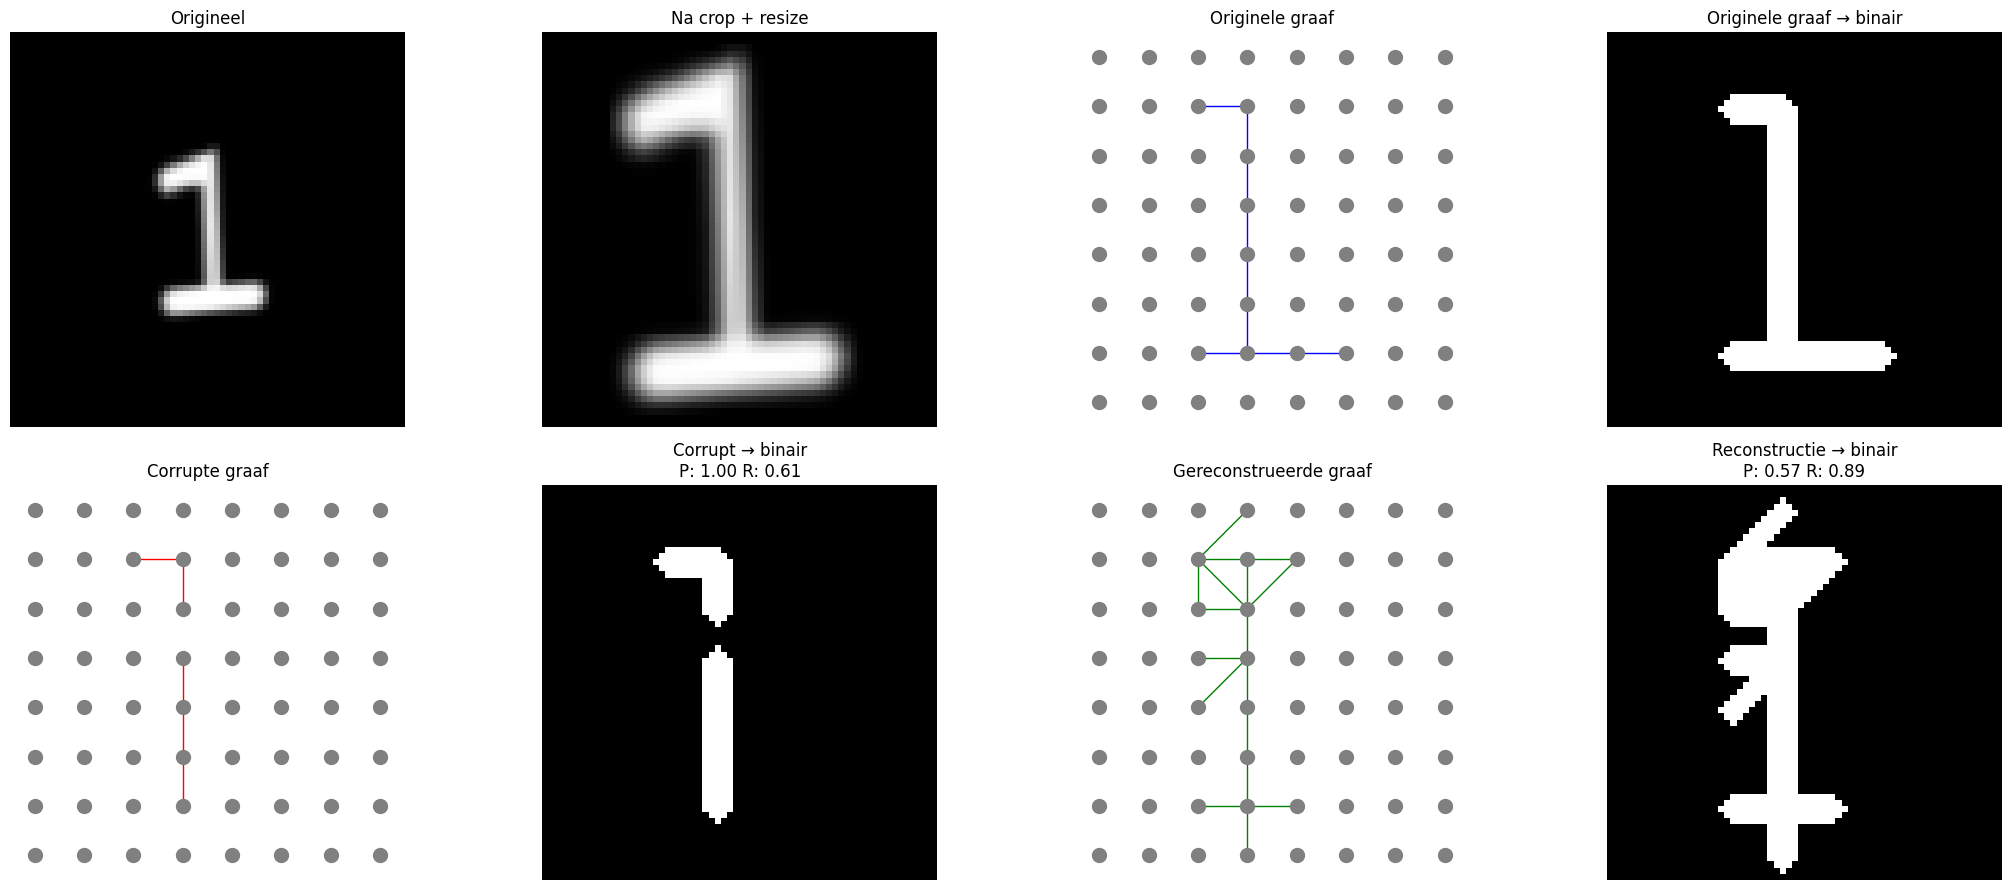

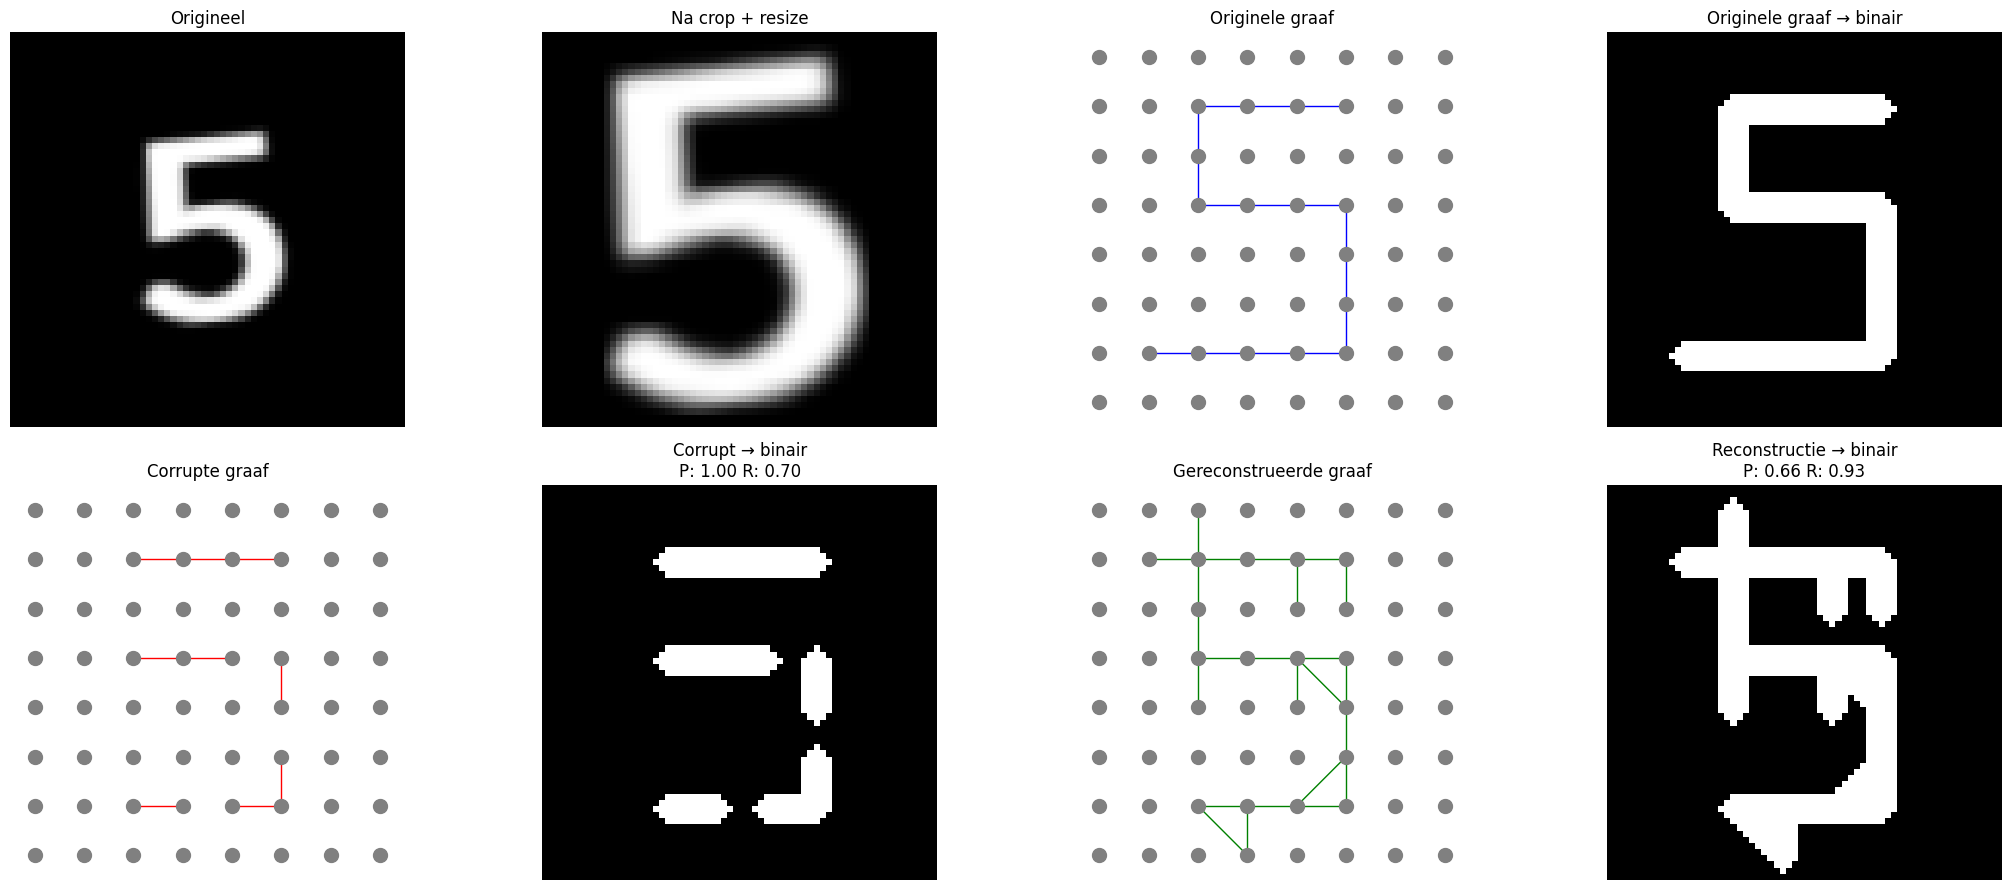

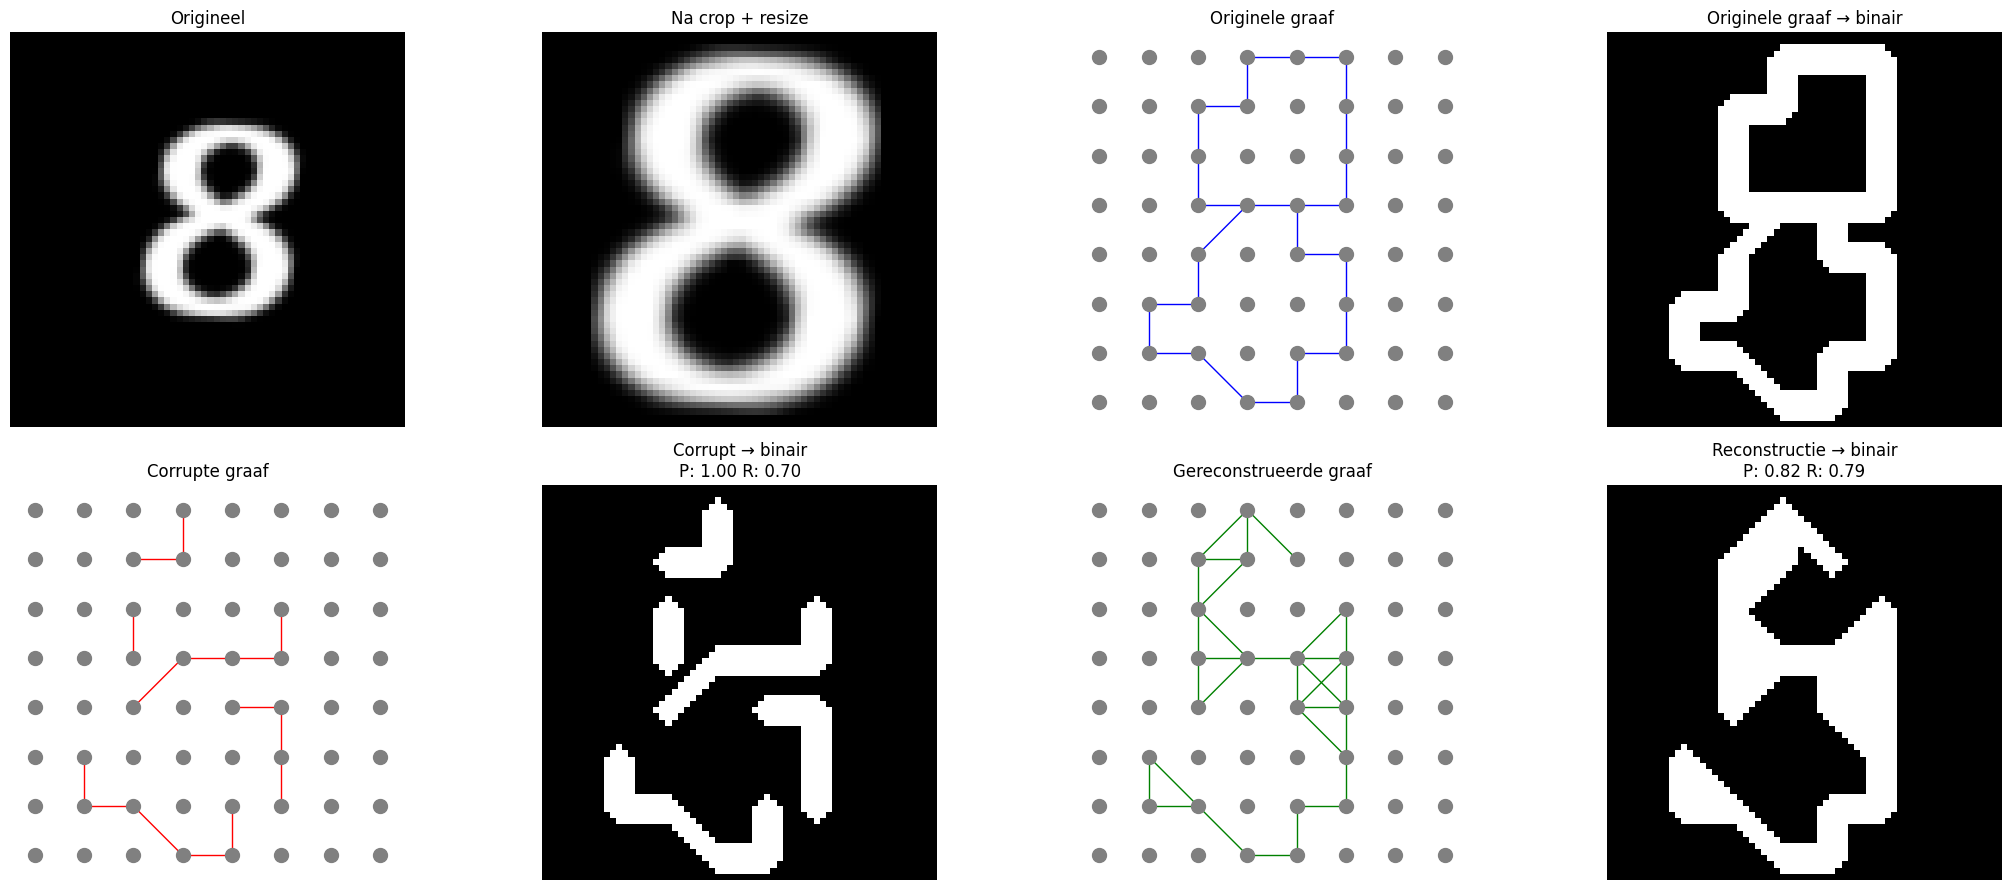

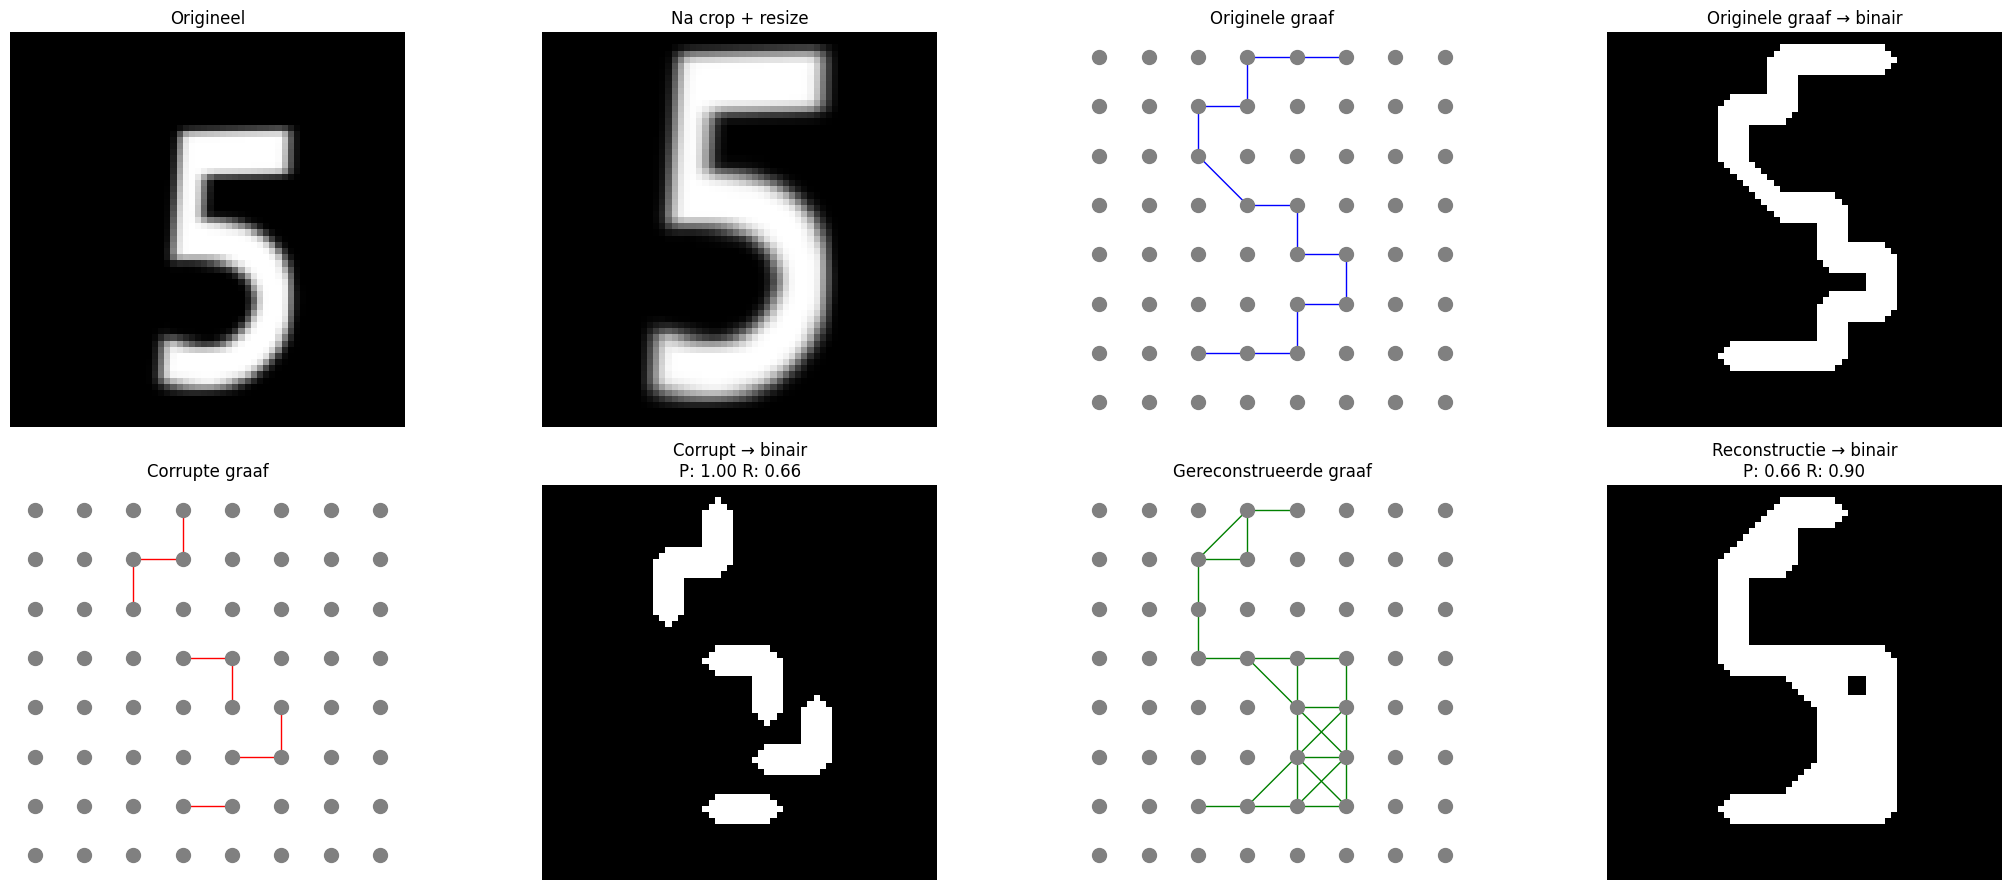

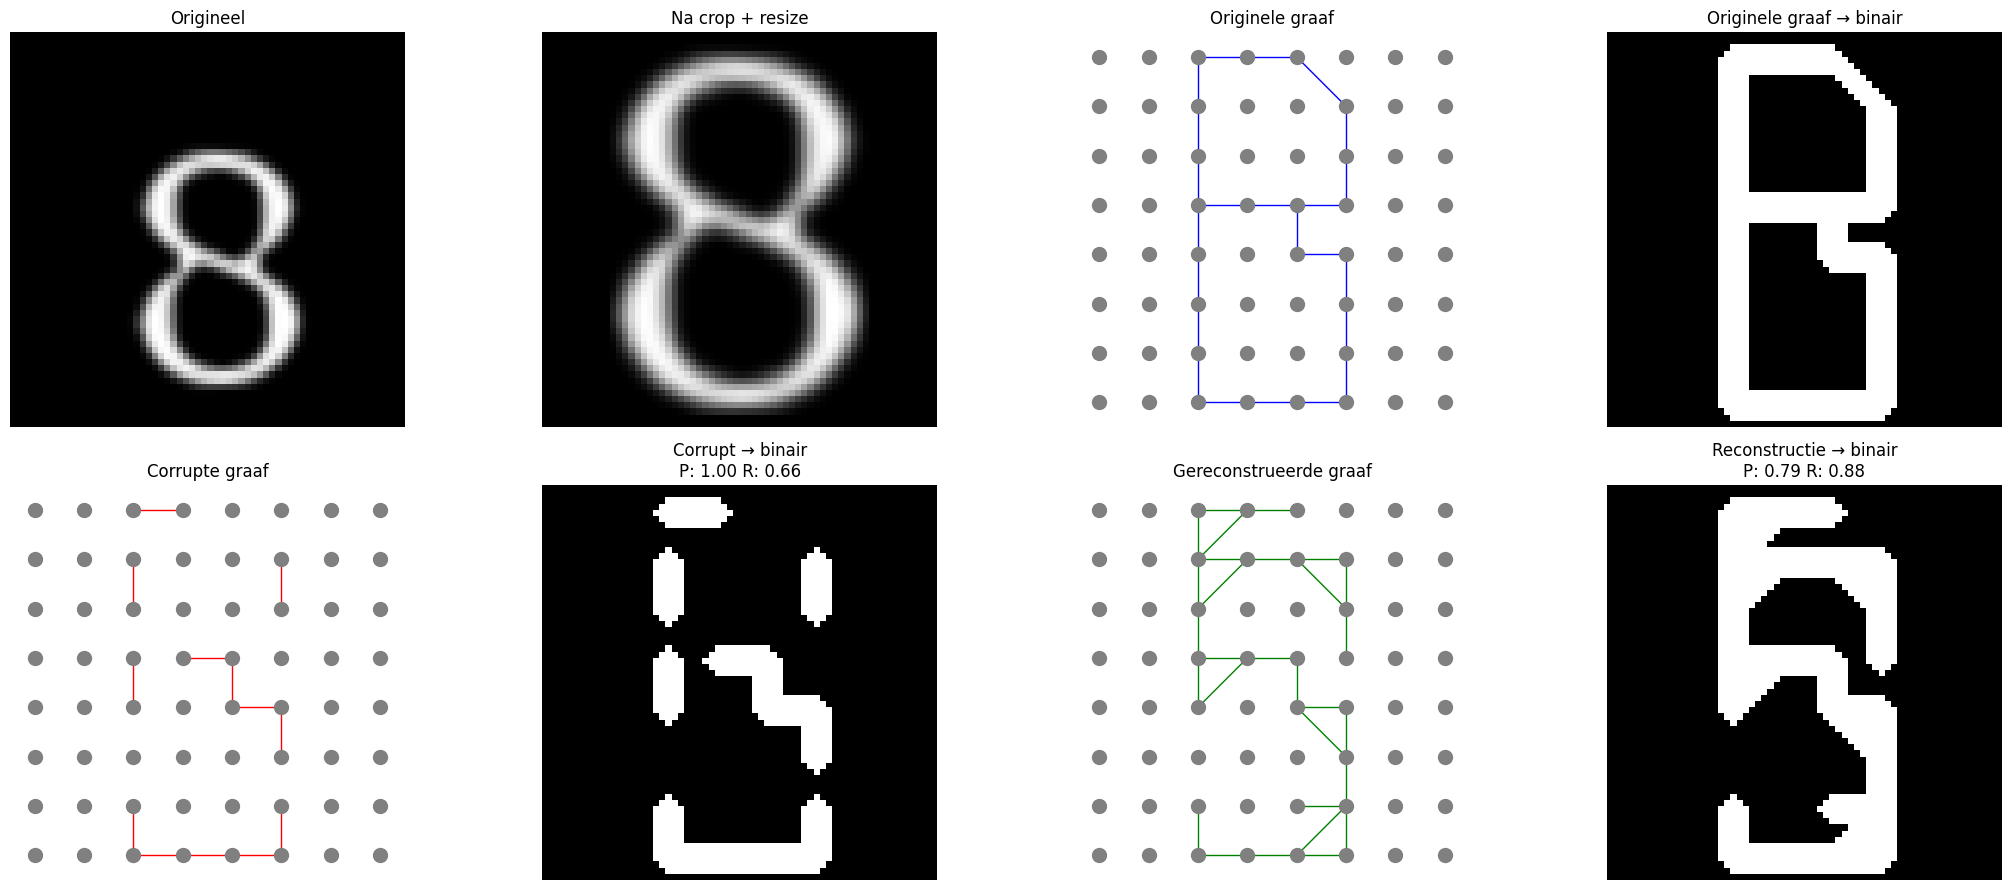

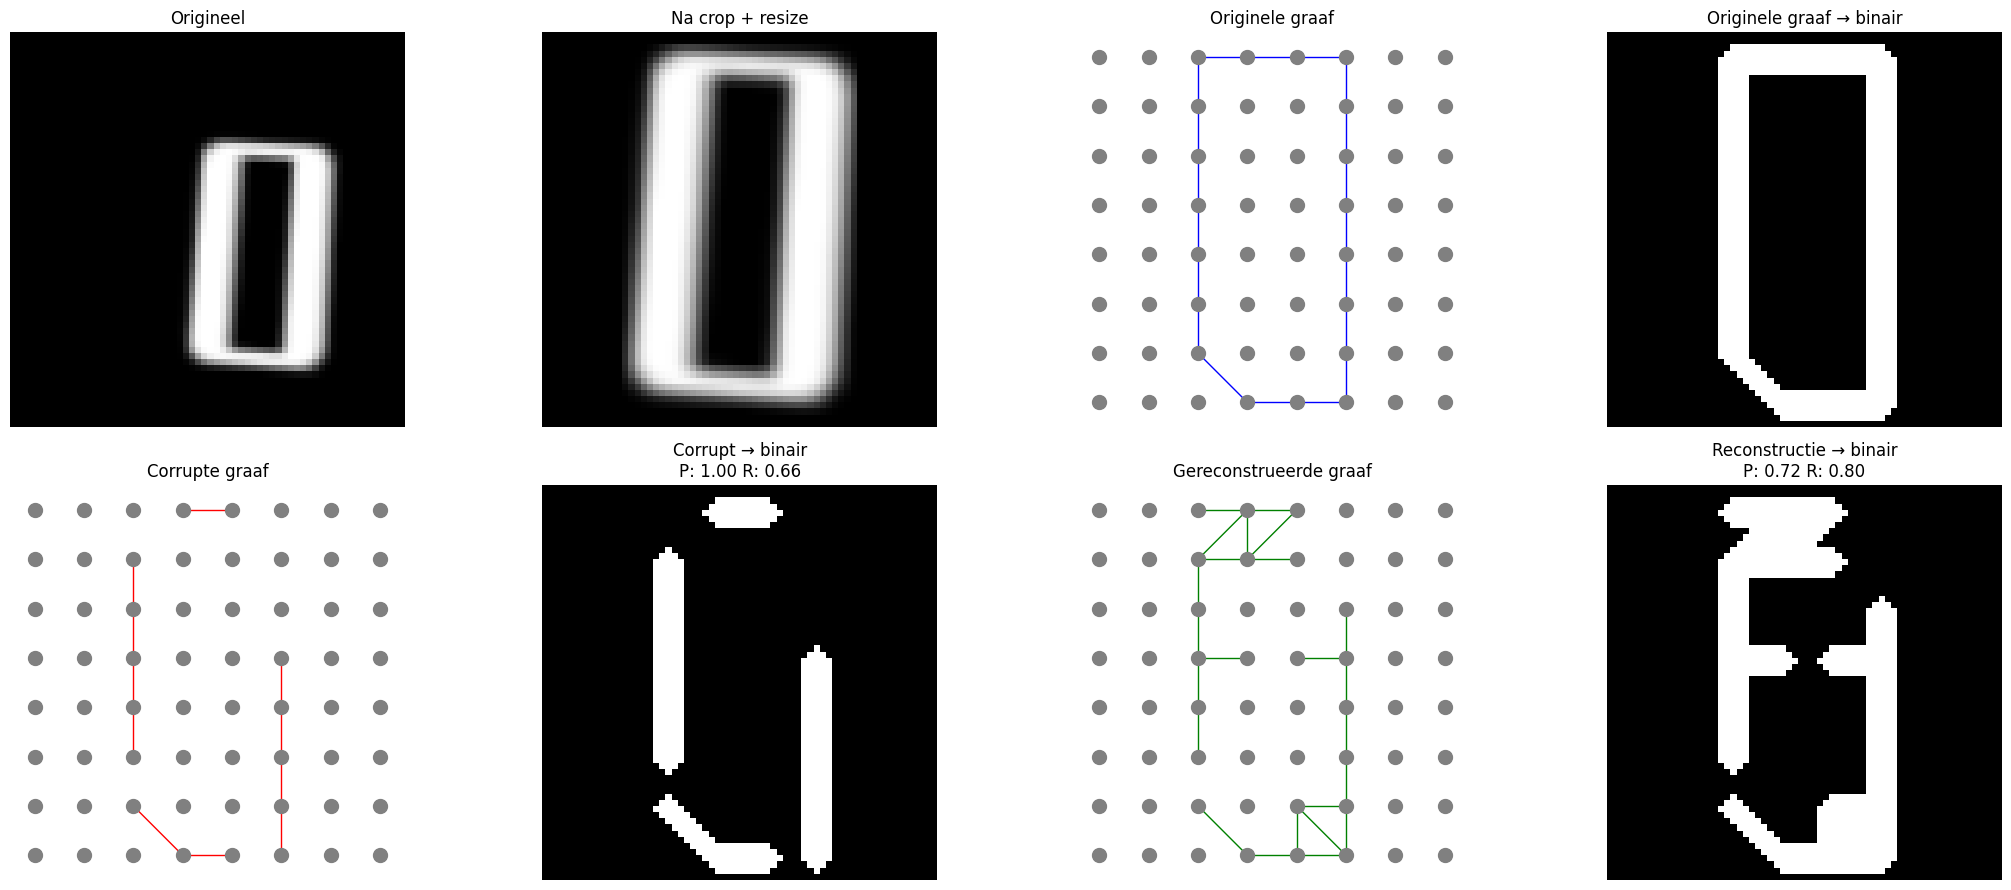

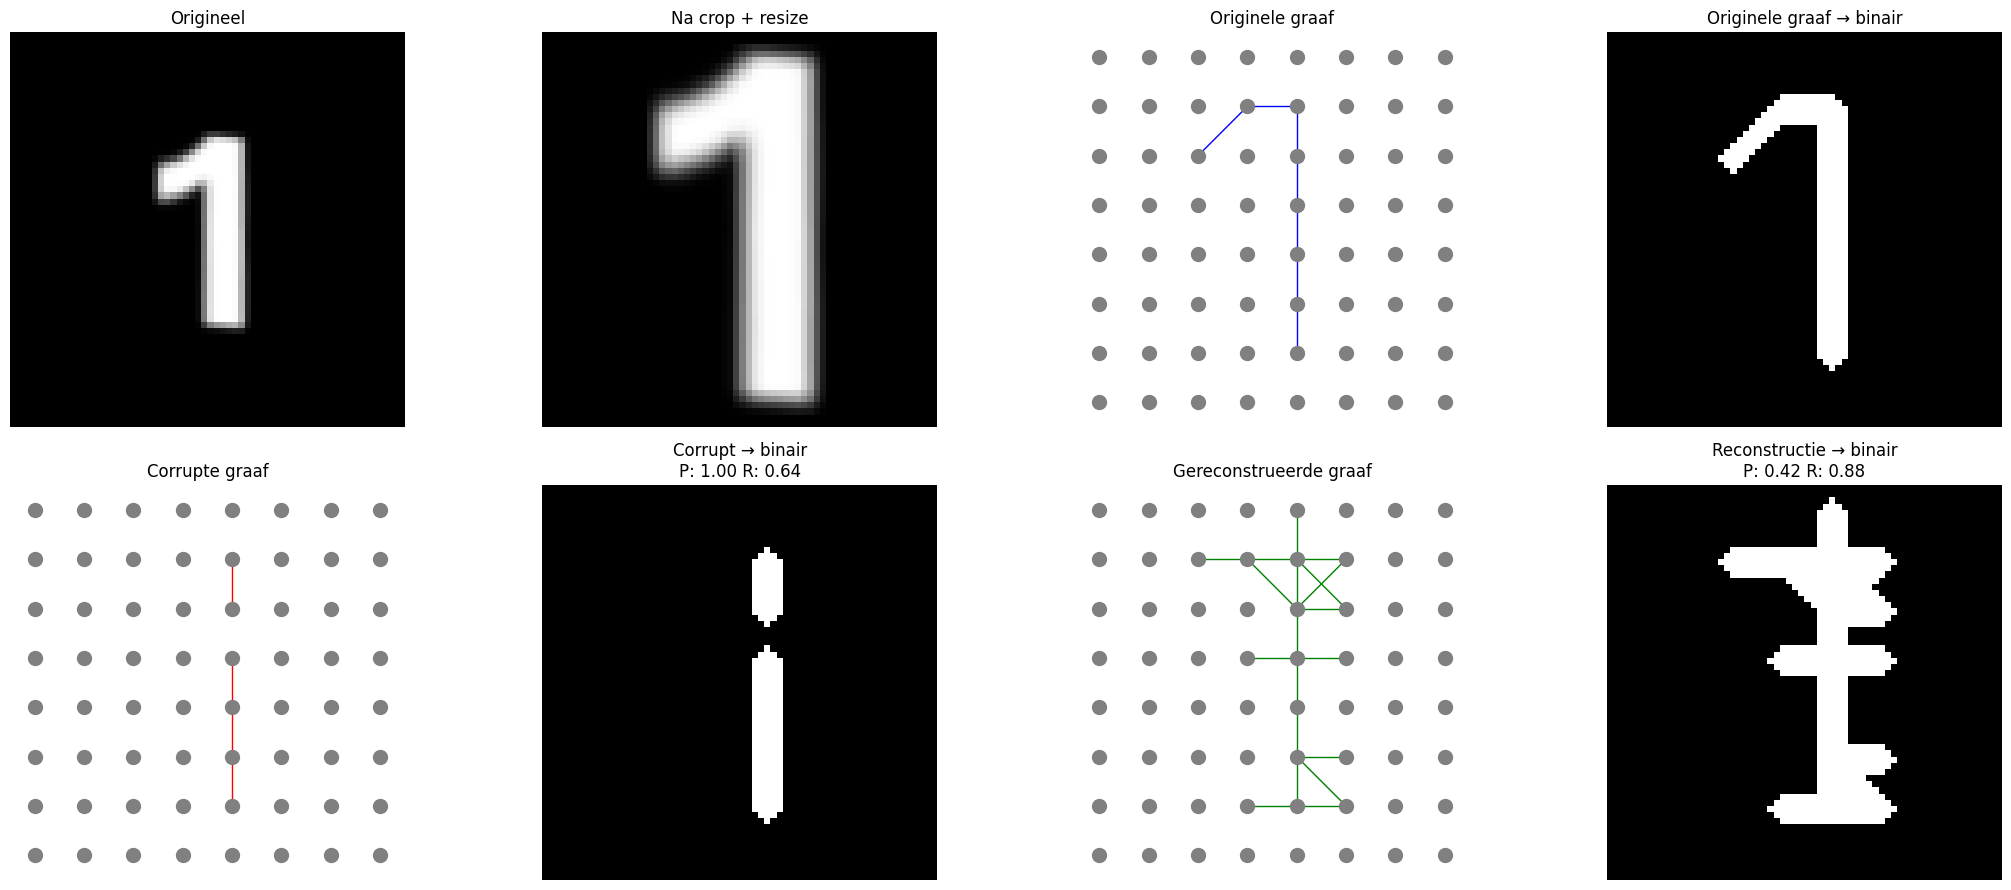

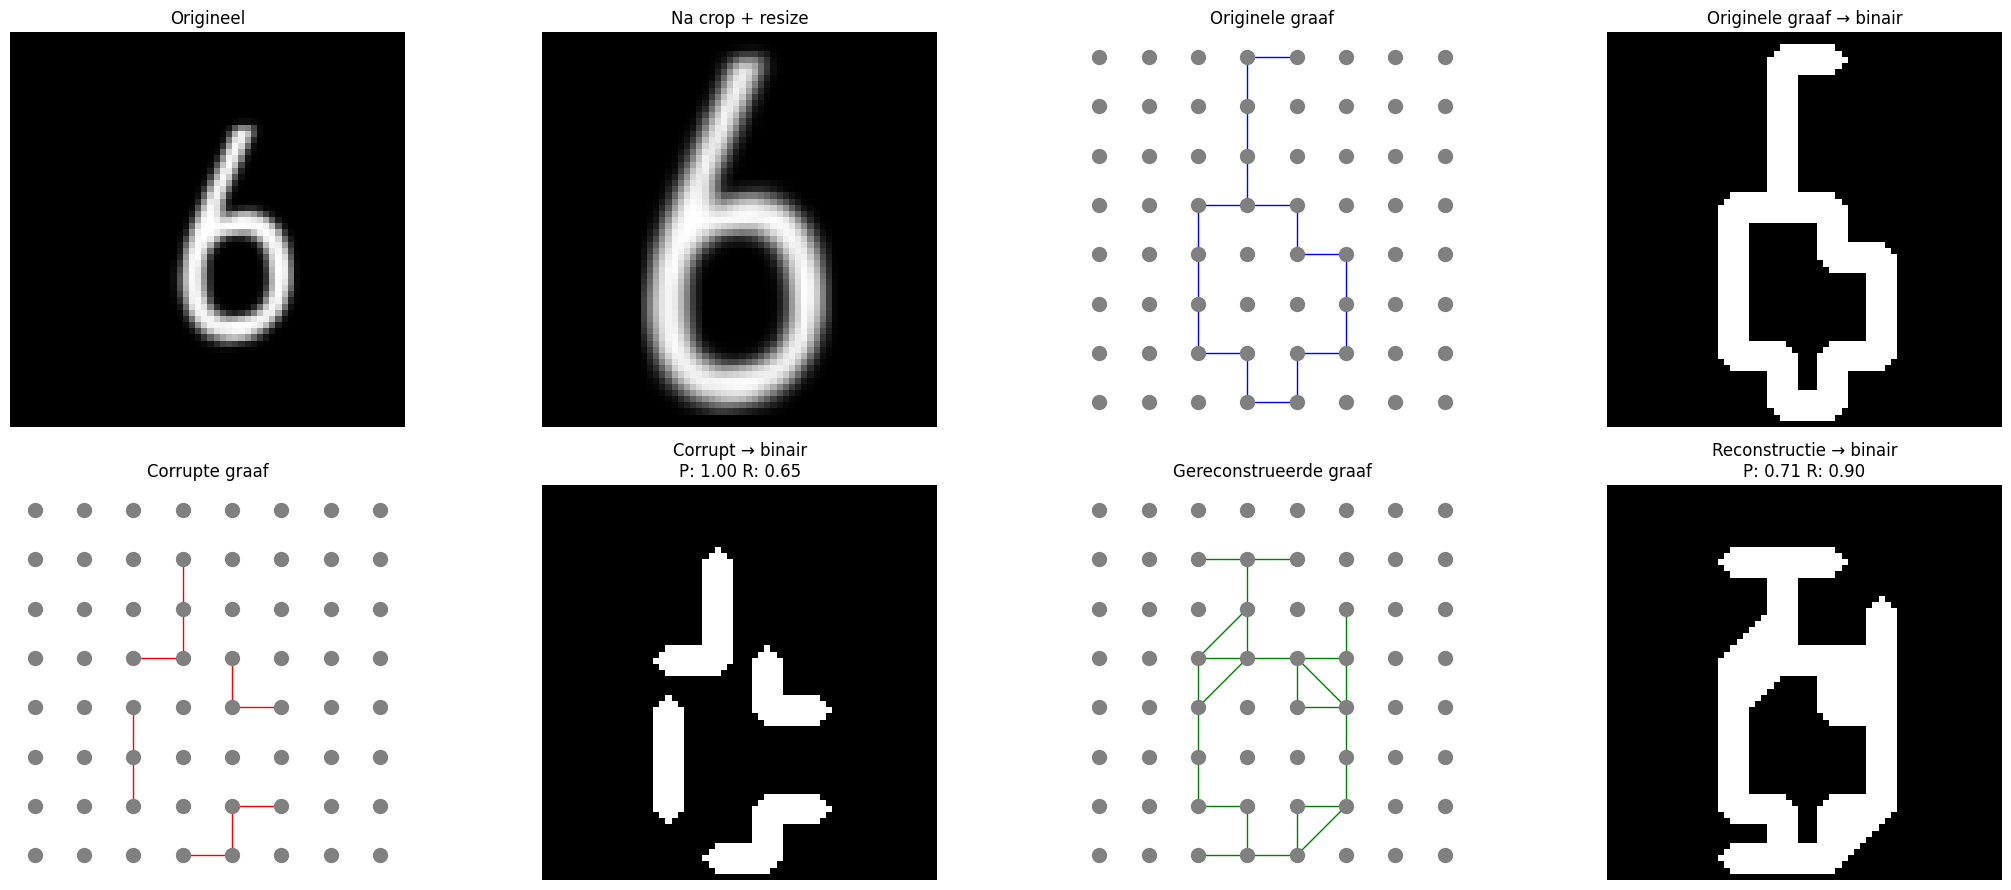

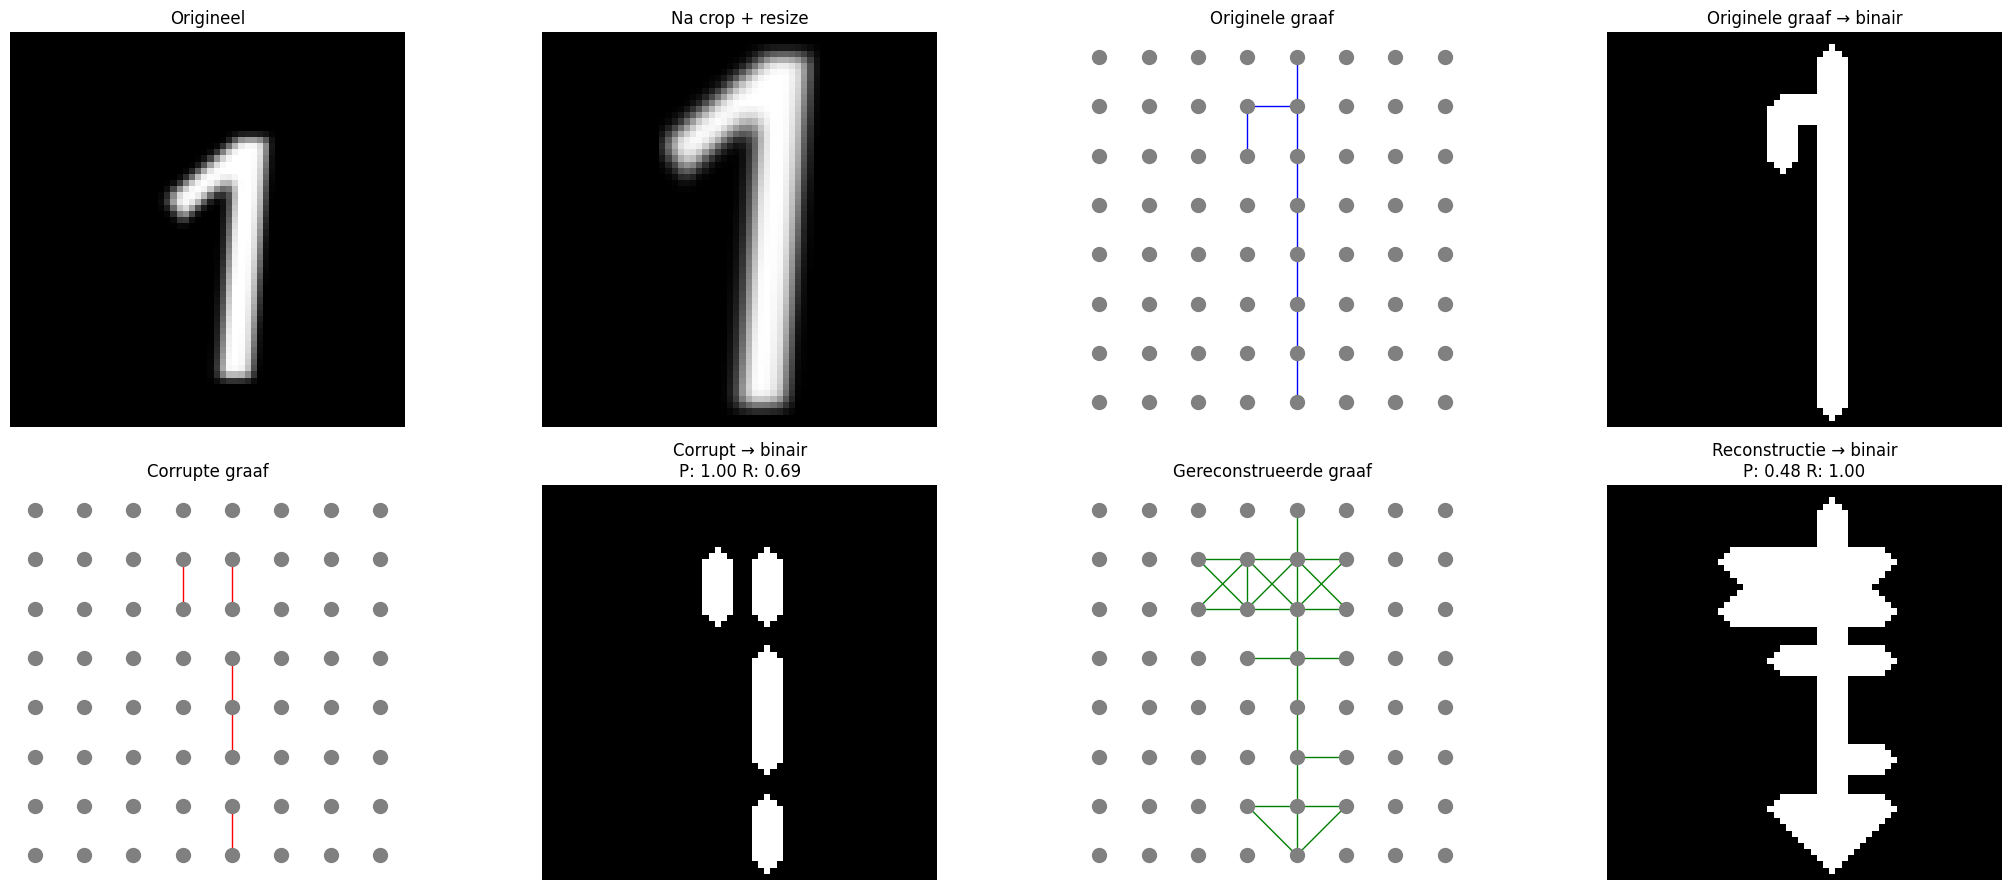

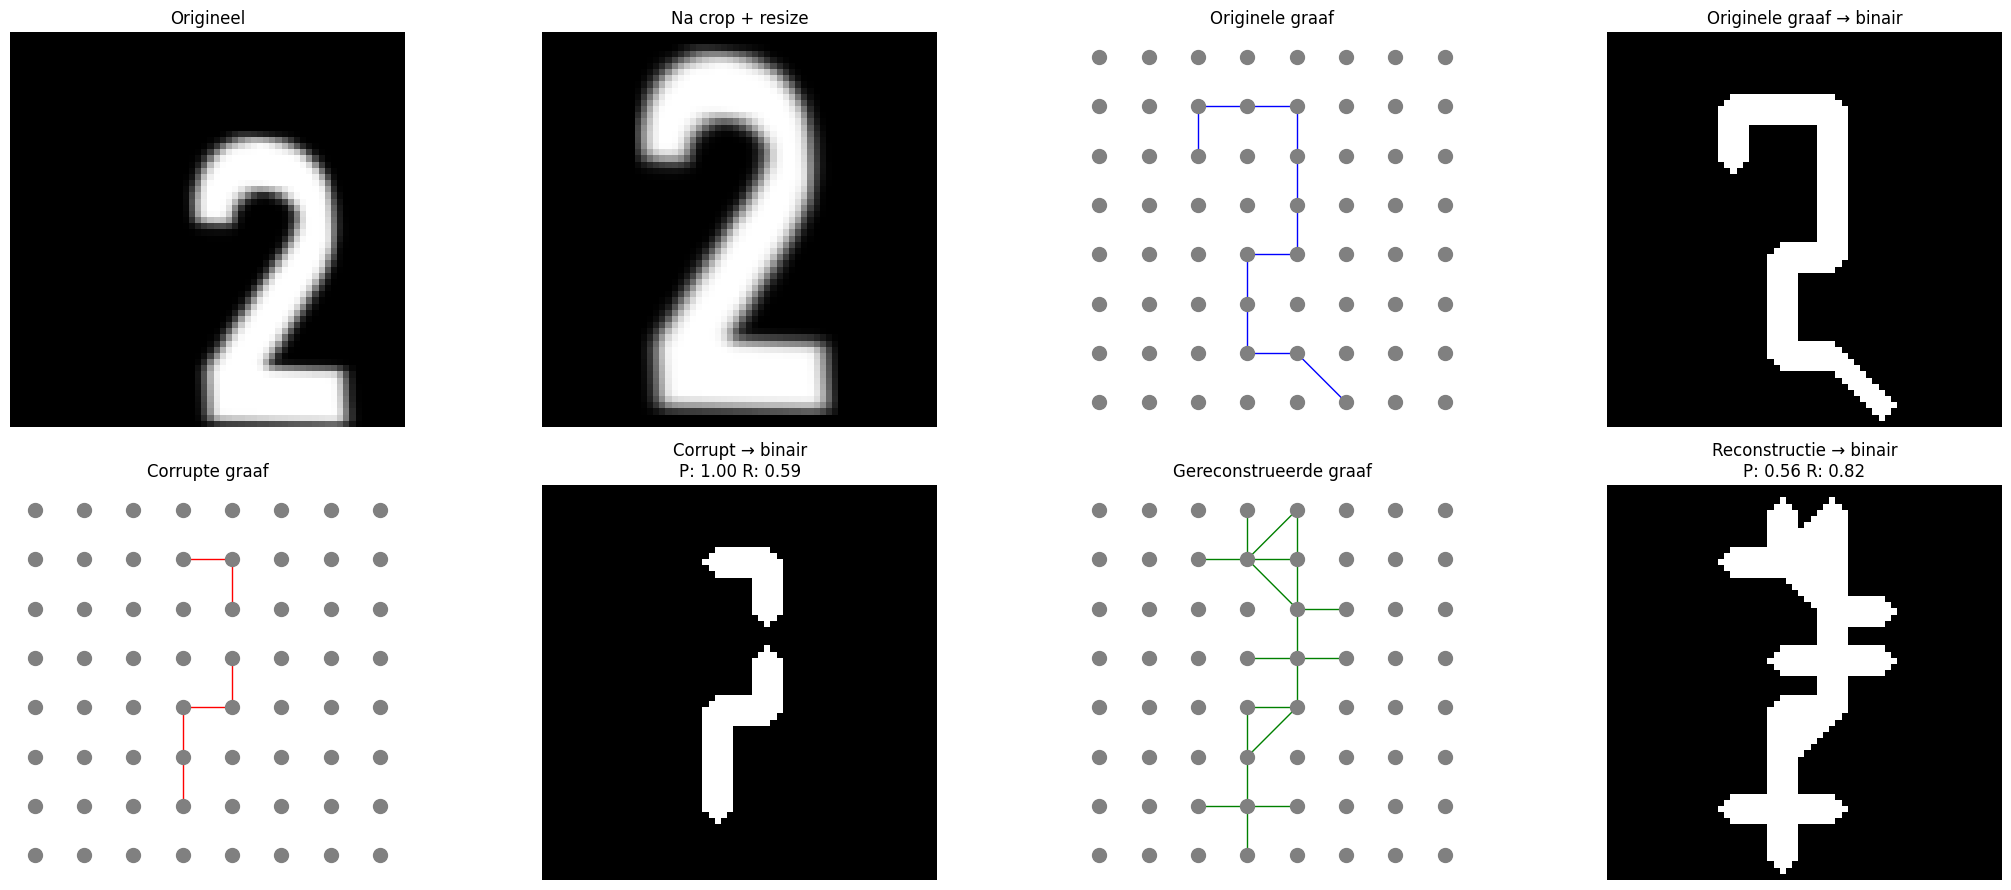

In [ ]:
chosen_drop_rate = 0.4  
num_visualizations = 10  
threshold = 0.96         

if chosen_drop_rate not in indices_per_rate:
    print(f"Drop rate {chosen_drop_rate} niet gevonden in indices_per_rate.")
else:
    selected_indices = random.sample(indices_per_rate[chosen_drop_rate], min(num_visualizations, len(indices_per_rate[chosen_drop_rate])))

    for idx in selected_indices:
        corrupted_data = test_dataset_corrupt[idx]
        original_data = test_dataset[idx]
        original_img = test_dataset.images[idx]

        reconstructed_edge_index = reconstruct_edges(corrupted_data, model, threshold=threshold)

        visualize_full_pipeline_precision_recall(
            idx=idx,
            original_img=original_img,
            original_data=original_data,
            corrupted_data=corrupted_data,
            reconstructed_edge_index=reconstructed_edge_index,
            drop_rate=chosen_drop_rate
        )
